# Análise de comentários do hipsters.tech

Esse é um projeto quase pessoal para mim. Eu sou muito fã do hipsters, e recomendo fortemente que todos escutem pelo menos um episódio. Um dos meus favoritos é sobre [Testes A/B](https://hipsters.tech/testes-ab-hipsters-59/).

Vamos começar com uma descrição geral dos dados. Eu implementei um crawler com a biblioteca Puppeteer para extrair algumas informações sobre os episódios (título, data, participantes e tags) e os comentários. O Hipsters usa Disqus no sistema de comentários, e até onde sei eles não oferecem uma API para esse tipo de extrção. O [código do crawler](https://github.com/luizpvas/hipsters_comentarios/blob/master/crawler.js) está no repositório desse projeto, se você tiver curiosidade.

In [20]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly
import plotly.express as px
import plotly.graph_objects as go
import spacy
import gensim
from plotly.subplots import make_subplots

nlp = spacy.load('pt_core_news_sm')

files = !ls data/

comments = []
episodes = []

for page_id in files:
    file = !cat data/{page_id}
    episode = json.loads(file[0])
    episodes.append(episode)
    date_parts = episode['releaseDate'].split('/')
    release_date = date_parts[2] + '-' + date_parts[1] + '-' + date_parts[0]
    for comment in episode['comments']:
        comments.append({
            'titulo': episode['title'],
            'data': release_date,
            'tags': episode['tags'],
            'participantes': episode['people'],
            'autor_comentario': comment['author'],
            'comentario': comment['comment']
        })

df = pd.DataFrame(comments)

# Visão geral

Antes de entrar nos detalhes, é sempre uma boa prática ter uma visão geral dos dados que estamos trabalhando. Para começar, vamos dar uma olhada nos totais e médias básicas.

In [21]:
qtde_episodios = df['titulo'].unique().size
qtde_comentarios = df.shape[0]
qtde_episodios_sem_comentarios = len(episodes) - qtde_episodios

# groupby(...).size() retorna um DataFrame com o valor agrupado e o total por grupo.
episodio_mais_comentarios = df.groupby('titulo').size().sort_values(ascending=False)[0]

print('Qtde. de episódios: {}'.format(qtde_episodios))
print('Qtde. total de comentários: {}'.format(qtde_comentarios))
print('Média de comentários por episódio: {}'.format(qtde_comentarios / qtde_episodios))
print('Qtde. de episódios sem comentários: {}'.format(qtde_episodios_sem_comentarios))
print('Maior qtde. de comentários em um episódio: {}'.format(episodio_mais_comentarios))

Qtde. de episódios: 163
Qtde. total de comentários: 4392
Média de comentários por episódio: 26.94478527607362
Qtde. de episódios sem comentários: 5
Maior qtde. de comentários em um episódio: 147


Uma coisa que me chamou atenção é a didstância entre a média (~ 27) e o episódio com mais comentários (147).

Média é uma coisa perigosa: se metade dos alunos tirou 0 e a outra metade 10, a média é 5, mas não representa ninguém.

Vamos dar uma olhada no **histograma** da qtde. de comentários por episódio.

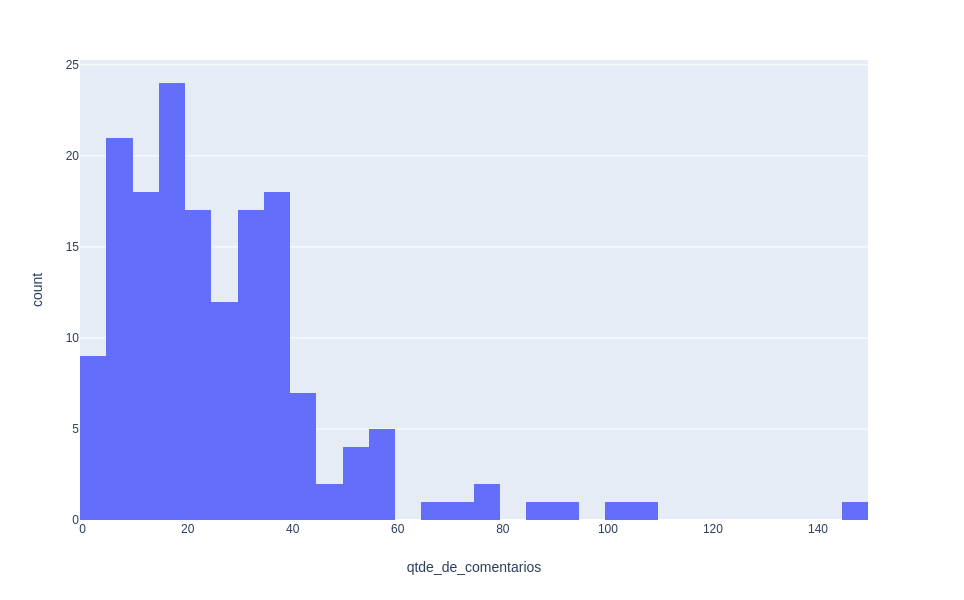

In [22]:
px.histogram(df.groupby('titulo').count().reset_index().rename(columns={'comentario': 'qtde_de_comentarios'}), x='qtde_de_comentarios', nbins=30)

O histograma comprova que o episódio com 147 comentários é um **evento isolado**. A maior parte dos episódios está no começo do gráfico, até ~50 comentários. Por curiosidade, eu fui ver qual era esse episódio com 147 comentários, e ele é o Tecnologias no Nubank – Hipsters \#01, o primeiro episódio. Vendo isso, nós podemos pensar na seguinte hipótese:

**Os episódios mais antigos terão mais comentários porque estão há mais tempo no ar**.

Vamos testar essa hipótese de duas formas:

* Calculando a correlação de pearson entre os dois atributos
* Plotando os dados com scatter e uma linha de tendência.

Adiantando o resultado (spoiler), existe uma correlação baixa (< 0.3) entre os atributos mas é possível visualizar de forma bem clara no gráfico.

*Dica: você pode colocar o cursor em cima dos pontos do gráfico para ver o título do episódio.*

In [23]:
grouped_df = df.groupby(['titulo', 'data']).count().reset_index()
grouped_df['semanas'] = grouped_df.index
corr = grouped_df['semanas'].corr(grouped_df['comentario'])

print('Correlação entre data de publicação e qtde. de comentários, sendo que 0 indica que não há correlação e 1 indica correlação perfeita.')
print('Valor: {}'.format(corr))

Correlação entre data de publicação e qtde. de comentários, sendo que 0 indica que não há correlação e 1 indica correlação perfeita.
Valor: 0.10407843615936567


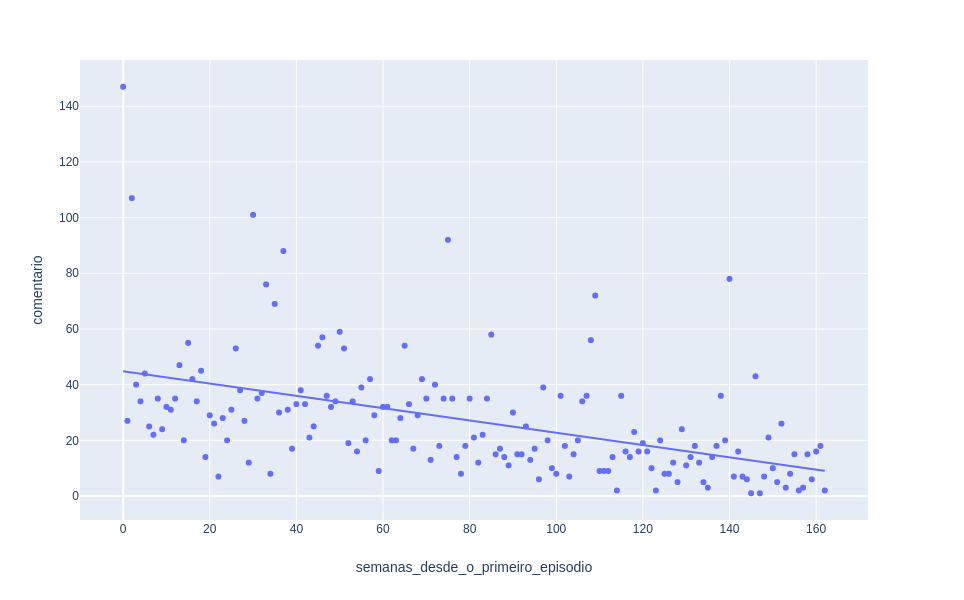

In [24]:
grouped_df = df.groupby(['titulo', 'data']).count().reset_index().sort_values('data').reset_index()
grouped_df['semanas_desde_o_primeiro_episodio'] = grouped_df.index
px.scatter(grouped_df, x='semanas_desde_o_primeiro_episodio', y='comentario', hover_data=['titulo'], trendline='ols')

# Algumas análises, ainda em uma visão geral.

## 1. Quais assuntos geram mais engajamento do público?

Engajamento é algo muito mais abrangente (e subjetivo) do que a qtde. de comentários, mas é o dado que temos pra hoje. Nós podemos agrupar por tags (cada episódio possui uma ou mais tags) para descobrir os assuntos que gera mais engajamento do público.

Na esquerda é mostrado uma contagem absoluta, e na direita a média por tag. A contagem não é legal porque existem, por exemplo, muito mais episódios sobre programação do que startup, fazendo a qtde. de comentários ser maior. Se a gente tirar a média, a qtde. de comentários é normalizada pela qtde. de episódios, o que gera uma métrica igual para todas as tags.

*Web*, *front-end*, *mobile* e *infra* são os 4 assuntos mais comentados, e *edição de vídeo* ficou por último.

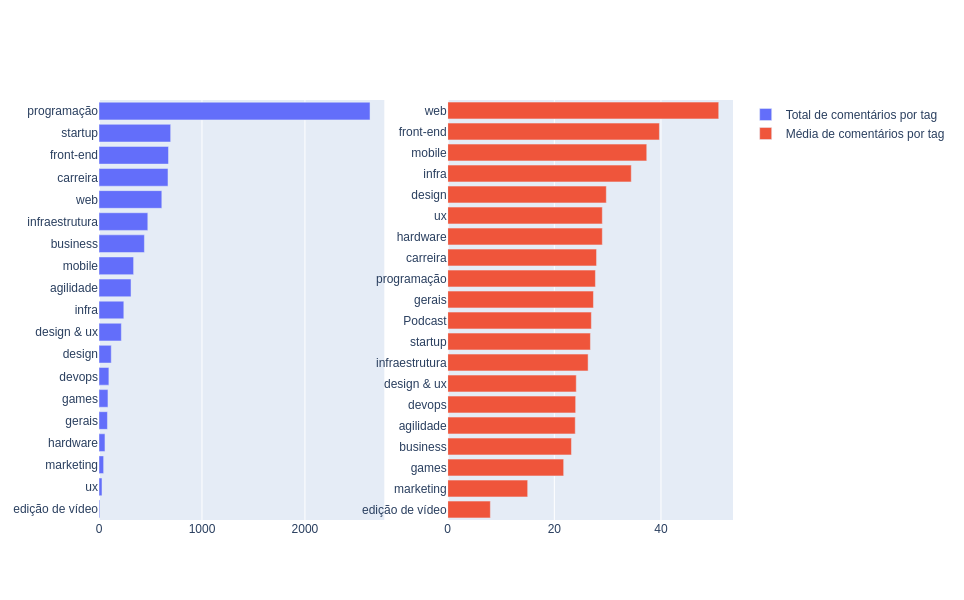

In [25]:
df_tags = df.tags.apply(pd.Series) \
    .merge(df, left_index=True, right_index=True) \
    .drop('tags', axis=1) \
    .melt(id_vars=['titulo', 'data', 'autor_comentario', 'comentario', 'participantes'], value_name='tag') \
    .drop('variable', axis=1) \
    .dropna()

comentarios_por_tag = df_tags.groupby('tag').count().reset_index().sort_values('comentario')
comentarios_por_tag.rename(columns={'comentario': 'qtde_de_comentarios'}, inplace=True)
# Remover a tag Podcast porque *todos* os episódios tem essa tag.
comentarios_por_tag = comentarios_por_tag[comentarios_por_tag['tag'] != 'Podcast']

media_comentarios_por_tag = df_tags.groupby(['tag', 'titulo']).agg({'comentario': 'size'}).reset_index() \
    .groupby('tag').mean().reset_index() \
    .sort_values('comentario', ascending=True)
media_comentarios_por_tag.rename(columns={'comentario': 'media_comentarios'}, inplace=True)

fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Bar(
        x = comentarios_por_tag['qtde_de_comentarios'],
        y = comentarios_por_tag['tag'],
        orientation='h',
        name = 'Total de comentários por tag'
    ),
    row=1, col=1
)

fig.add_trace(
    go.Bar(
        x = media_comentarios_por_tag['media_comentarios'],
        y = media_comentarios_por_tag['tag'],
        orientation = 'h',
        name= 'Média de comentários por tag'
    ),
    row=1, col=2
)

fig.update_layout(height=600)
fig.show()

## 2. Em quantos episódios as pessoas comentam?

Em outras palavras, das pessoas que deixam um comentário, quantas voltam para deixar novos comentários no futuro?

Meu palpite antes de rodar essa análise é que a maioria das pessoas deixa um único comentário em um único episódio, e um grupo pequeno de pessoas comentam com frequência, em vários episódios.

![](grafico.png)

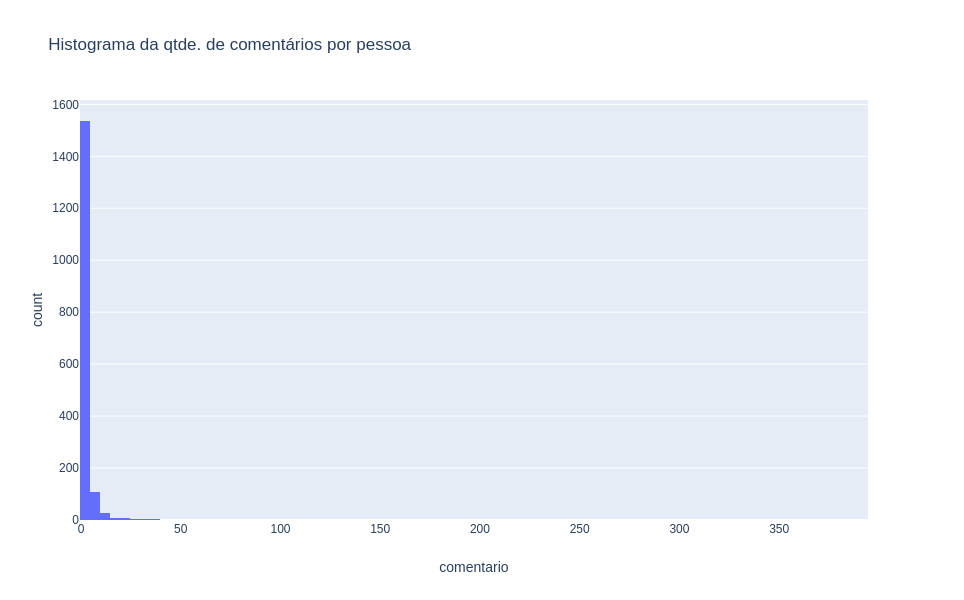

In [26]:
px.histogram(df.groupby('autor_comentario').count(), x='comentario', nbins=100, title="Histograma da qtde. de comentários por pessoa")

Esse gráfico me deixou um pouco... supreso. Ele segue o formato que eu tinha imaginado, mas os valores são bem mais drásticos. Quem será a pessoa que deixou quase 400 comentários?

Vamos dar uma olhada nas 5 pessoas que comentaram mais vezes:

In [27]:
df.groupby('autor_comentario').count().sort_values('comentario', ascending=False).head()

,titulo,data,tags,participantes,comentario
autor_comentario,,,,,
Paulo Silveira,393,393,393,393,393
Maurício Linhares,135,135,135,135,135
Tiago Aguiar Moreira,48,48,48,48,48
Roberta Arcoverde,40,40,40,40,40
Welton Vaz de Souza,37,37,37,37,37


Bem, eu deveria ter imaginado. Das 5 pessoas, 3 são participantes dos episódios que estão provavelmente respondendo comentários dos ouvintes. Vamos plotar novamente o gráfico de frequência, dessa vez ignorando os participantes.

O gráfico é bem parecido com o anterior, porém sem os valores extremos. 

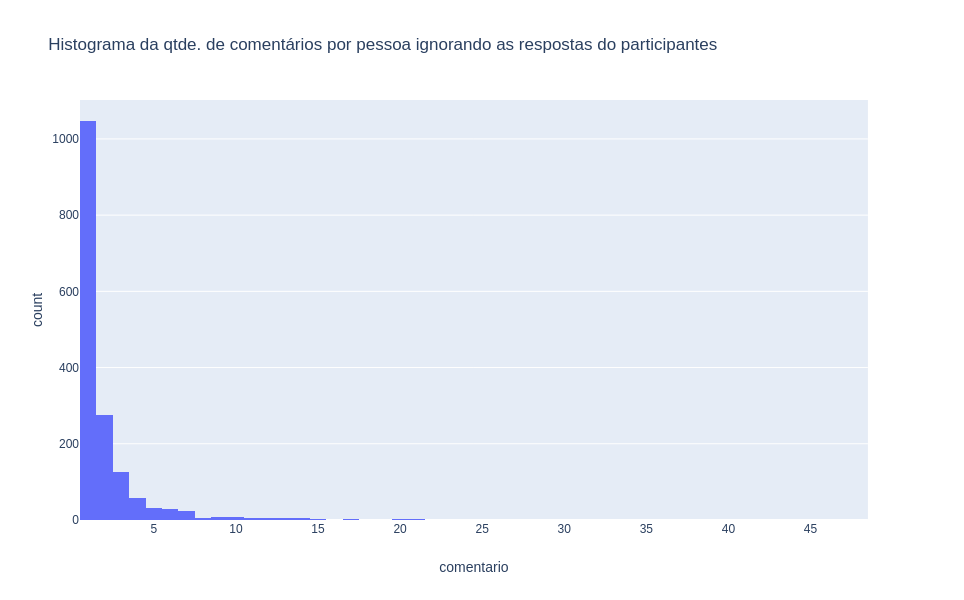

In [28]:
all_participantes = set()
for participantes in df['participantes']:
    for p in participantes:
        all_participantes.add(p)

px.histogram(
    df[~df['autor_comentario'].isin(all_participantes)].groupby('autor_comentario').count(),
    x = 'comentario',
    nbins = 48,
    title = 'Histograma da qtde. de comentários por pessoa ignorando as respostas do participantes'
)

# Mais algumas anaĺises, dessa vez olhando para o conteúdo dos comentários

Como esse projeto é puramente exploratório, eu pensei em dois casos razoavelmente simples de implementar e que seriam bacanas de ver:

1. Os episódios que os ouvintes mais gostaram, analisando o sentimento.
2. Quais os principais temas/palavras-chave citados em cada uma das categorias (tags)

Bem, vamos começar

## 1. Quais os episódios mais amados ♥?

Análise de sentimento é uma coisa complicada. E abrangante. E vaga. Infelizmente, o Tone Analyzer do Watson só funciona para inglês e francês no momento, então a gente vai ter que se virar com... contagem de palavras. Essa é a abordagem mais simples para análise de sentimento, mas é o que temos para hoje.

Eu vou usar a base [OpLexicon V3.0](http://ontolp.inf.pucrs.br/Recursos/downloads-OpLexicon.php), que contém palavras positivas, negativas e neutras.

A tabela abaixo mostra os 5 episódios com maior score positivo.

In [29]:
positive = []

with open('lexico_v3.0.txt') as f:
    lines = f.read().split('\n')
    for line in lines:
        if ',' in line:
            word, type_, score, _nsei = line.split(',')
            if score == '1':
                positive.append(word)

def build_spacy_doc(comentario):
    return nlp(comentario)

def split_tokens(doc):
    tokens = []
    for t in doc:
        if not t.is_stop and not t.is_punct and t.is_alpha:
            tokens.append(t.lower_)
    return tokens

def atribuir_score_positivo(doc):
    score = 0
    for token in doc:
        if token.lower_ in positive:
            score += 1
    return score

df['doc'] = df['comentario'].apply(lambda x: build_spacy_doc(x))    
df['positivo'] = df['doc'].apply(lambda x: atribuir_score_positivo(x))
df['tokens'] = df['doc'].apply(lambda x: split_tokens(x))

contagem_positivo = df.groupby('titulo').agg({'positivo': 'sum', 'comentario': 'size'})
contagem_positivo.rename(columns={'comentario': 'qtde_comentarios', 'positivo': 'palavras_positivas'}, inplace=True)
contagem_positivo.sort_values('palavras_positivas', ascending=False).head(5)

,palavras_positivas,qtde_comentarios
titulo,,
Carreira em Tecnologia – Hipsters #31,389,101
Mulheres na Tecnologia – Hipsters #34,201,76
Grandes livros de Tecnologia – Hipsters #113,200,72
Tecnologias no Nubank – Hipsters #01,194,147
Tendências em Tecnologia para 2018 – Hipsters #77,187,92


Falando da minha experiência própria como ouvinte, o público do hipsters é bem amigável. Por conta disso, eu imagino que a qtde. de palavras positivas esteja correlacionada com a qtde. de comentários.

A linha de tendência no gráfico abaixo apresenta uma característica interessante. Os pontos abaixo da linha são episódios que estão indo mal na proporção comentários/feedback positivos, e os pontos acima da linha representam os episódios que estão indo bem na proporção comentários/feedback positivo.

Na verdade... não é justo falar "indo bem" e "indo mal". Análise de sentimento é algo muito subjetivo, e a abordagem de contagem de palavras que usamos não é muito confiável. Estar acima ou abaixo da tendência é apenas mais um indicador no meio de tantos.

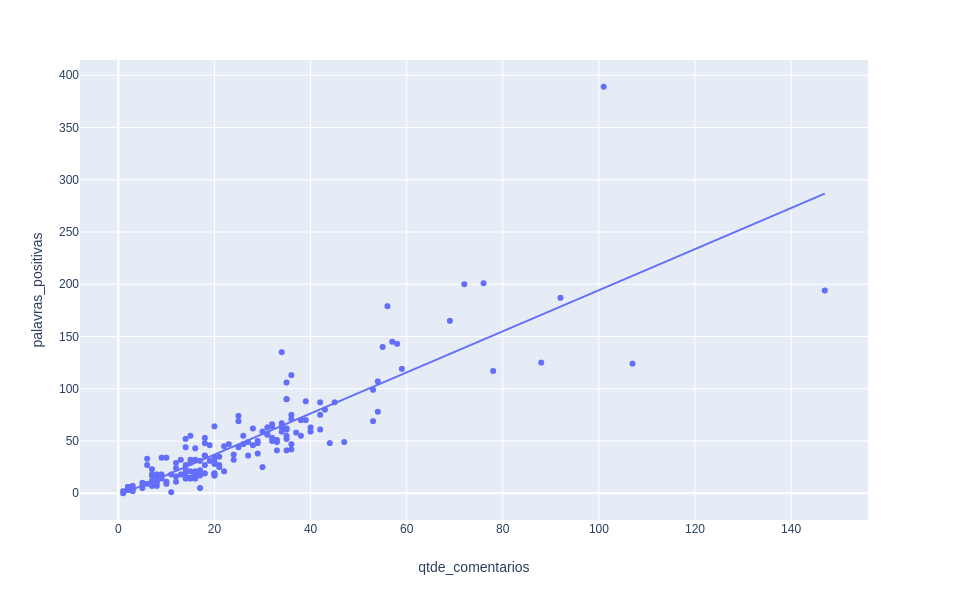

In [30]:
px.scatter(contagem_positivo.reset_index(), x='qtde_comentarios', y='palavras_positivas', trendline='ols', hover_data=['titulo'])

## Quais os principais temas/palavras-chave por assunto?

Para extrair as palavras-chave, nós vamos usar o algoritmo TF-IDF. O TF-IDF é puramente "estatístico" - ele apenas se preocupa com qtde. de palavras em cada documento e a frequência das palavras na coleção. A ideia por trás do TF-IDF é que as palavras importantes para um documento vão aparecer várias vezes nesse documento e poucas vezes nos outros. 

Nesse caso, nós vamos rodar o TF-IDF apenas curiosidade, mas ele poderia nos ajudar em outros casos: 

* Filtrar stopwords que não estão presentes na lista padrão das bibliotecas (lembre-se, o IDF pode chegar a 0 se a palavra aparecer em todos os documentos da base).
* Usar como um dos atributos de um modelo de predição para classificar comentários por assunto.
* Ajudar na interpretação do resultado modelagem de tópico (como LDA)

A lista abaixo mostra as 10 palavras com maior score no TF-IDF por tag.

In [31]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel

# O resultado ficou um pouco mais relevante excluindo os episódios com mais comentários.
top_episodios = df.groupby('titulo').count().reset_index().sort_values('comentario', ascending=False).head()['titulo']

docs_per_tag = {}
for index, row in df[~df['titulo'].isin(top_episodios)].iterrows():
    for tag in row['tags']:
        if tag != 'Podcast':
            if tag in docs_per_tag:
                docs_per_tag[tag] += ' ' + ' '.join(row['tokens'])
            else:
                docs_per_tag[tag] = ' '.join(row['tokens'])

words = [text.split(' ') for text in docs_per_tag.values()]
dct = Dictionary(words)
corpus = [dct.doc2bow(line) for line in words]
model = TfidfModel(corpus)

for tag, text in docs_per_tag.items():
    item = [t for t in dct.doc2bow(text.split(' ')) if t[1] > 2]
    scores = sorted(model[item], key=lambda x: -x[1])
    #print(item)
    palavras = [dct[score[0]] for score in scores[:10]]
    print('Tag: {}'.format(tag))
    print(' '.join(palavras))
    print('')

Tag: front-end
angular react jquery vue spa ember vuejs angularjs híbrido delphi

Tag: programação
spring mulheres xamarin react mainframe java angular livros studio flutter

Tag: agilidade
scrum kanban testes roberta agile unidade automação json ceci dapper

Tag: business
mulheres scrum totvs homens kanban bb atendimento mulher mvc ti

Tag: startup
academia bitcoin smartfit startup bb atendimento fundos netflix warren clt

Tag: mobile
kotlin xamarin flutter híbrido studio android native ionic nativo react

Tag: infraestrutura
monitoramento bb roberta containers checkout paypal dapper pdf braintree emerson

Tag: infra
roberta checkout paypal containers dapper braintree emerson relacionais aws laptop

Tag: design
disqus lind sketch axure balsamic dashboard heurísticas pantufa protótipo aba

Tag: design & ux
designer disqus sketch protótipo lind figma prototipar ux dashboard axure

Tag: ux
lind dashboard b aba atalho decisões testes teste funciona link

Tag: carreira
mulheres computação 

# Encerrando...

Acho que vou parar por aqui, mas ainda teria muita coisa legal para extrair dessa base.
Se você tiver interesse, o repositório com o código do crawler e comentários está [no github](https://github.com/luizpvas/hipsters_comentarios).

Me manda on oi lá no [twitter](https://twitter.com/luizpvasc) também se quiser conversar sobre data science :-)